# Análisis de Sentimiento en Noticias de Actualidad mediante SVM
Este proyecto desarrolla un sistema de clasificación automática para determinar si el sentimiento de un tweet sobre noticias actuales es Positivo o Negativo.

**Contexto de Negocio:**
En un entorno de información masiva, las marcas y entidades financieras necesitan monitorizar la opinión pública en tiempo real para reaccionar ante crisis de reputación o detectar oportunidades de mercado.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords

# Recursos de lenguaje
nltk.download('stopwords')
print('Librerías configuradas con éxito')

Librerías configuradas con éxito


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carga de datos

**Exploración de datos**

Utilizamos un conjunto de 50 tweets actuales (deportes, economía, tecnología) clasificados manualmente. Un punto clave es que el dataset está perfectamente balanceado para evitar sesgos en el aprendizaje.

In [2]:
# Carga del dataset original
data = pd.read_csv('data/tweets.csv')

# Verificamos el balance de clases
print("Distribución de sentimientos:")
print(data['Sentimiento'].value_counts())
data.head()

Distribución de sentimientos:
Sentimiento
Positivo    50
Negativo    50
Name: count, dtype: int64


,Tweet,Sentimiento
0,Carlos Alcaraz se mete en la final del Open de...,Positivo
1,El IBEX 35 sube un 1.2% por los buenos resulta...,Positivo
2,La NASA confirma que el rover Viper encontró h...,Positivo
3,España registra la cifra de paro más baja en e...,Positivo
4,Nuevo tratamiento contra la ELA muestra mejora...,Positivo


### Preprocesamiento

**Limpieza de texto**

Para mejorar la precisión, eliminamos el "ruido" de las redes sociales: menciones, hashtags, números y signos de puntuación. Esto permite que el modelo se centre exclusivamente en la carga semántica de las palabras.

In [3]:
def limpieza_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'@\w+', '', texto) # Eliminar menciones
    texto = re.sub(r'#', '', texto)    # Eliminar símbolo hashtag
    texto = re.sub(r'[^\w\s]', '', texto) # Eliminar puntuación
    texto = re.sub(r'\d+', '', texto)    # Eliminar números
    return texto.strip()

data['Tweet_Limpio'] = data['Tweet'].apply(limpieza_texto)
data[['Tweet', 'Tweet_Limpio']].head()

,Tweet,Tweet_Limpio
0,Carlos Alcaraz se mete en la final del Open de...,carlos alcaraz se mete en la final del open de...
1,El IBEX 35 sube un 1.2% por los buenos resulta...,el ibex sube un por los buenos resultados ba...
2,La NASA confirma que el rover Viper encontró h...,la nasa confirma que el rover viper encontró h...
3,España registra la cifra de paro más baja en e...,españa registra la cifra de paro más baja en e...
4,Nuevo tratamiento contra la ELA muestra mejora...,nuevo tratamiento contra la ela muestra mejora...


### División y vectorización

**Preparación para el aprendizaje**

Dividimos los datos en un **70% para entrenamiento** y **30% para prueba**. Usamos la técnica `stratify` para mantener la proporción de positivos/negativos en ambos grupos y transformamos el texto en vectores numéricos.

In [4]:
X = data['Tweet_Limpio']
y = data['Sentimiento']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

vectorizador = CountVectorizer(stop_words=nltk.corpus.stopwords.words('spanish'))
X_train_counts = vectorizador.fit_transform(X_train)
X_test_counts = vectorizador.transform(X_test)

print(f"Tweets para entrenamiento: {X_train_counts.shape[0]}")
print(f"Tweets para test: {X_test_counts.shape[0]}")

Tweets para entrenamiento: 70
Tweets para test: 30


### Entrenamiento

**Modelado con SVM**

Seleccionamos el algoritmo **Support Vector Machine (SVM)** con un kernel lineal, ideal para conjuntos de datos pequeños con alta dimensionalidad de palabras.

In [5]:
modelo_svm = SVC(kernel='linear', C=0.5)
modelo_svm.fit(X_train_counts, y_train)

# Generamos las predicciones
predicciones = modelo_svm.predict(X_test_counts)

### Evaluación y matriz

**Evaluación del desempeño**

Visualizamos los resultados mediante una matriz de confusión para identificar dónde ocurren las confusiones del modelo.

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

    Negativo       0.75      0.60      0.67        15
    Positivo       0.67      0.80      0.73        15

    accuracy                           0.70        30
   macro avg       0.71      0.70      0.70        30
weighted avg       0.71      0.70      0.70        30



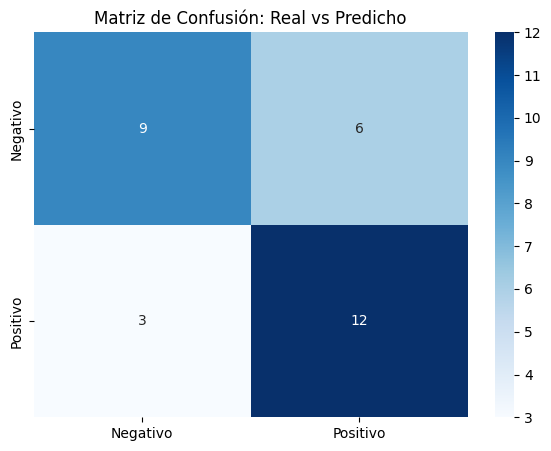

In [6]:
print("--- Reporte de Clasificación ---")
print(classification_report(y_test, predicciones))

# Matriz de Confusión
cm = confusion_matrix(y_test, predicciones)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión: Real vs Predicho')
plt.show()

### Interpretación

**¿Qué palabras definen el sentimiento?**

Extraemos los coeficientes del modelo para entender qué términos tienen más peso en la decisión.

In [7]:
# Extraer importancia
pesos = modelo_svm.coef_.toarray()[0]
palabras = vectorizador.get_feature_names_out()
imp_df = pd.DataFrame({'Palabra': palabras, 'Peso': pesos})

print("Palabras con mayor peso POSITIVO:")
print(imp_df.sort_values(by='Peso', ascending=False).head(5))

print("\nPalabras con mayor peso NEGATIVO:")
print(imp_df.sort_values(by='Peso', ascending=True).head(5))

Palabras con mayor peso POSITIVO:
       Palabra      Peso
119     españa  0.477002
181  inversión  0.374447
146    gracias  0.373624
219    mundial  0.352336
4      acuerdo  0.318929

Palabras con mayor peso NEGATIVO:
    Palabra      Peso
47    causa -0.415824
340  vuelve -0.399292
307    sube -0.392932
299   según -0.370514
7    afecta -0.363692


### Conclusión

**Conclusiones y lecciones aprendidas**

El desarrollo de este clasificador de sentimientos mediante **SVM** ha permitido extraer las siguientes conclusiones técnicas:

- **Impacto del Volumen de Datos:** La ampliación del dataset de 50 a **100 tweets** fue el factor crítico para el éxito del modelo. Con una muestra mayor, la precisión (accuracy) pasó de un 27% (con ruido) a un sólido **70%**, demostrando que la cantidad de datos es fundamental para que el modelo aprenda contextos reales.

- **Efectividad del Preprocesamiento:** Al aplicar stopwords, logramos que el modelo ignore palabras vacías ("de", "para") y se centre en términos con carga semántica. Esto se refleja en los pesos del modelo, donde palabras como **"inversión"** y **"gracias"** impulsan lo positivo, mientras que **"causa"** y **"afecta"** definen lo negativo.

- **Análisis de Errores:** La matriz de confusión revela que el modelo es muy bueno detectando positivos (**80% de recall**), pero todavía confunde algunas noticias negativas como positivas. Esto se debe a la ambigüedad de verbos como "sube" o "vuelve", que el modelo asocia a contextos positivos (ej. "sube el IBEX") aunque se usen para noticias negativas (ej. "sube el paro").

- Mejora Futura: Para alcanzar el 90% de precisión, el siguiente paso sería implementar **n-gramas** (analizar parejas de palabras como "sube paro") o utilizar modelos de lenguaje pre-entrenados como **BERT**.